In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../../..'))) # access sibling directories
sys.path.append("C:\\Users\\lasse\\Documents\\GitHub\\BayesFlow")

from src.python.settings import summary_meta_validation, probability_meta_validation
from src.python.networks import HierarchicalInvariantNetwork, ModelProbabilityNetwork
from src.python.models import HierarchicalSdtMptSimulator, MainSimulator
from src.python.losses import softmax_loss
from src.python.helpers import n_clust_obs_f_f
from src.python.visualization import perf_tester

import numpy as np

from tensorflow.keras.backend import clear_session

from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.optimizers import Adam
from functools import partial
import matplotlib.pyplot as plt

from bayesflow.trainers import ModelComparisonTrainer
from bayesflow.amortizers import MultiModelAmortizer

In [2]:
# Hack to correctly set facecolor to white
# matplotlib 3.5 only sets facecolor if a plot was already created 
_ = plt.figure()
plt.rcParams['figure.facecolor'] = 'w'

<Figure size 432x288 with 0 Axes>

# Load network

In [24]:
# Reset network
clear_session()

In [25]:
summary_net = HierarchicalInvariantNetwork(summary_meta_validation)
probability_net = ModelProbabilityNetwork(probability_meta_validation)

amortizer = MultiModelAmortizer(probability_net, summary_net)

simulator = MainSimulator(HierarchicalSdtMptSimulator())

In [26]:
# Training steps
epochs=30 
iterations_per_epoch=1000

# Cosine decaying learning rate
initial_lr = 0.0005
decay_steps = epochs*iterations_per_epoch
alpha = 0
lr_schedule = CosineDecay(
    initial_lr, decay_steps, alpha=alpha
    )

# Checkpoint path for loading pretrained network and saving the final network
checkpoint_path = "c:\\Users\\lasse\\documents\\hierarchical_model_comparison_project\\checkpoints\\02_bridge_sampling_comparison\\non_nested_models"

trainer = ModelComparisonTrainer(
    network=amortizer, 
    generative_model=simulator, 
    loss=partial(softmax_loss),
    optimizer=partial(Adam, lr_schedule),
    checkpoint_path=checkpoint_path,
    skip_checks=True
    )

# Sample size
n_clusters = 25
n_obs = 50

Networks loaded from c:\Users\lasse\documents\hierarchical_model_comparison_project\checkpoints\02_bridge_sampling_comparison\non_nested_models\ckpt-30


# Get OOD score

## Utility functions

In [6]:
class NoiseGenerator:

    def __init__(self):
        pass

    def generate_single(self, model_index, n_clusters, n_obs):
        """ Generates a single hierarchical data set. """
        
        RNG = np.random.default_rng()
        data = RNG.integers(low=0, high=2, size=(n_clusters, n_obs, 2)) 
        #data = RNG.integers(low=-10, high=11, size=(n_clusters, n_obs, 2))

        return data

In [7]:
class SingleModelSimulator:

    def __init__(self, simulator):
        
        self.simulator = simulator

    def simulate(self, batch_size, n_obs, model, n_vars):
        """ Simulates a batch of hierarchical data sets, solely from a single model. """

        K, N = n_obs
        
        model_indices = np.repeat(model, batch_size)

        X_gen = np.zeros((batch_size, K, N, n_vars), dtype=np.float32)

        for b in range(batch_size):
            X_gen[b] = self.simulator.generate_single(model_indices[b], K, N)

        return X_gen

    def __call__(self, batch_size, n_obs, model, n_vars=2):
        return self.simulate(batch_size, n_obs, model, n_vars)

In [8]:
def get_max_activation(data, probability_net, summary_net, method):
    """ Gets the inference networks' last-layer-activation, either before or after 
    passing it through the softmax function. """

    if method=='max_softmax':
        activations = probability_net.predict(summary_net(data))['m_probs']
    if method=='max_logits':
        activations = probability_net.get_logits(summary_net(data))    
          
    max_activation = np.max(activations, axis=1)

    return max_activation

## Data generation

In [9]:
#simulator = MainSimulator(HierarchicalSdtMptSimulator())
single_model_simulator = SingleModelSimulator(HierarchicalSdtMptSimulator())
noise_simulator = MainSimulator(NoiseGenerator())

#sdtmpt_data = simulator(batch_size=5000, n_obs=n_clust_obs_f_f(n_clusters, n_obs), n_vars=2)
#sdt_data = sdtmpt_data[2][sdtmpt_data[0][:,0]==1]
#mpt_data = sdtmpt_data[2][sdtmpt_data[0][:,0]==1]
sdt_data = single_model_simulator(batch_size=5000, n_obs=n_clust_obs_f_f(n_clusters, n_obs), model=0)
mpt_data = single_model_simulator(batch_size=5000, n_obs=n_clust_obs_f_f(n_clusters, n_obs), model=1)
noise_data1 = noise_simulator(batch_size=5000, n_obs=n_clust_obs_f_f(n_clusters, n_obs), n_vars=2)[2]
noise_data2 = noise_simulator(batch_size=5000, n_obs=n_clust_obs_f_f(n_clusters, n_obs), n_vars=2)[2]

## max_softmax

In [10]:
#sdtmpt_max_softmax = get_max_activation(sdtmpt_data, probability_net, summary_net, 'max_softmax')
sdt_max_softmax = get_max_activation(sdt_data, probability_net, summary_net, 'max_softmax')
mpt_max_softmax = get_max_activation(mpt_data, probability_net, summary_net, 'max_softmax')
noise_max_softmax = get_max_activation(noise_data1, probability_net, summary_net, 'max_softmax')
print(np.mean(sdt_max_softmax), np.mean(mpt_max_softmax), np.mean(noise_max_softmax))

0.93648493 0.925144 1.0


Text(0.5, 1.0, 'MaxSoftmax')

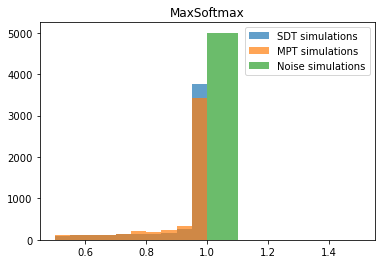

In [11]:
plt.hist(sdt_max_softmax, alpha=0.7, label='SDT simulations')
plt.hist(mpt_max_softmax, alpha=0.7, label='MPT simulations')
plt.hist(noise_max_softmax, alpha=0.7, label='Noise simulations')
plt.legend()
plt.title('MaxSoftmax')

## max_logits

In [27]:
#import tensorflow as tf
#tf.random.set_seed(2023) 
# fixes wildly differing results - but why are they so different when reloading the net in the first place??

sdt_max_logits = get_max_activation(sdt_data, probability_net, summary_net, 'max_logits')
mpt_max_logits = get_max_activation(mpt_data, probability_net, summary_net, 'max_logits')
#noise_max_logits = get_max_activation(noise_data, probability_net, summary_net, 'max_logits')
noise_max_logits1 = get_max_activation(noise_data1, probability_net, summary_net, 'max_logits')
noise_max_logits2 = get_max_activation(noise_data2, probability_net, summary_net, 'max_logits')
print(np.mean(sdt_max_logits), np.mean(mpt_max_logits), np.mean(noise_max_logits1), np.mean(noise_max_logits2))

0.5749536 0.35319212 21.282028 21.28429


Text(0.5, 1.0, 'MaxLogit')

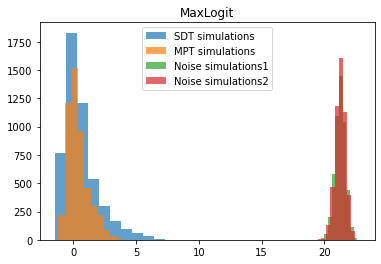

In [28]:
plt.hist(sdt_max_logits, alpha=0.7, label='SDT simulations')
plt.hist(mpt_max_logits, alpha=0.7, label='MPT simulations')
#plt.hist(noise_max_logits, alpha=0.7, label='Noise simulations')
plt.hist(noise_max_logits1, alpha=0.7, label='Noise simulations1')
plt.hist(noise_max_logits2, alpha=0.7, label='Noise simulations2')
plt.legend()
plt.title('MaxLogit')

# Inspect predictions 

## SDT MPT data

In [14]:
sims_sdtmpt = simulator(batch_size=5000, n_obs=n_clust_obs_f_f(n_clusters, n_obs), n_vars=2)
preds_sdtmpt = probability_net.predict(summary_net(sims_sdtmpt[2]))['m_probs']

ECE = 0.010


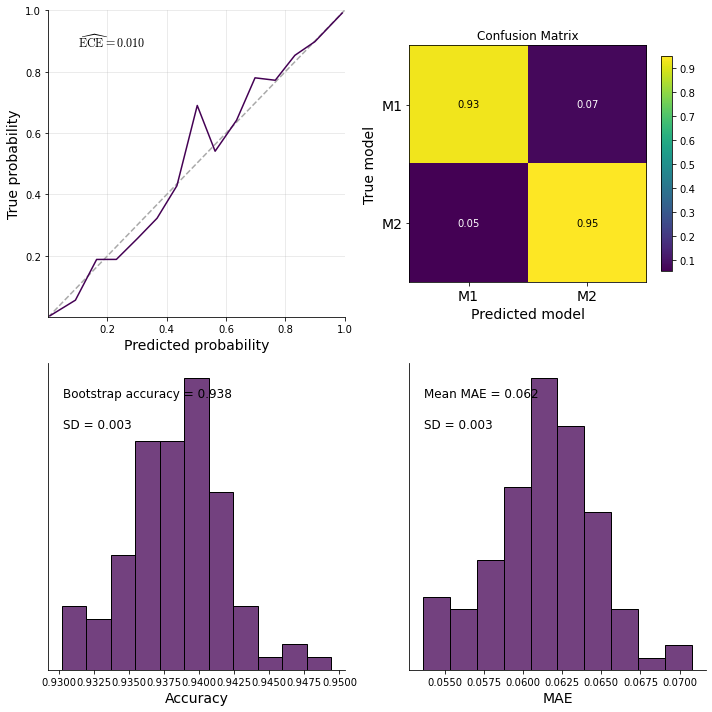

In [15]:
val_sims_sdtmpt = {'X' : sims_sdtmpt[2], 'm' : sims_sdtmpt[0]}
perf_tester(probability_net, summary_net, val_sims_sdtmpt, n_cal_bins=15)

## Noisy data

In [16]:
sims_noise = noise_simulator(batch_size=100, n_obs=n_clust_obs_f_f(n_clusters, n_obs), n_vars=2)
sims_noise[2]

array([[[[ -5.,   2.],
         [ -6.,  -7.],
         [  0.,  -8.],
         ...,
         [ -5.,  -2.],
         [  0.,   4.],
         [ -8.,   1.]],

        [[  4.,   6.],
         [  6.,   2.],
         [  5.,  -2.],
         ...,
         [ -9.,  -1.],
         [  2.,   9.],
         [  2.,   6.]],

        [[  8.,   5.],
         [  6.,  -8.],
         [ 10., -10.],
         ...,
         [  7.,   2.],
         [  3.,  -1.],
         [ -5.,   2.]],

        ...,

        [[  3.,  -8.],
         [-10.,   6.],
         [-10.,  -8.],
         ...,
         [  9.,  -5.],
         [  0.,  -1.],
         [ -9.,  -4.]],

        [[ -1.,  -7.],
         [ 10.,   5.],
         [ -2.,  -6.],
         ...,
         [ -1.,   9.],
         [  0.,   7.],
         [  8.,   1.]],

        [[ -7.,   2.],
         [  6.,  -2.],
         [-10.,   9.],
         ...,
         [  0.,   9.],
         [ -4.,  10.],
         [  8.,   1.]]],


       [[[  1.,  -3.],
         [  9.,  -3.],
         [ 10.

In [17]:
# check that both columns are random
np.mean(sims_noise[2], axis=(0,1,2))

array([0.014768, 0.014576], dtype=float32)

In [18]:
preds_noise = probability_net.predict(summary_net(noise_data1))['m_probs']
print(preds_noise[:10,:])
print(probability_net.get_logits(summary_net(sims_noise[2]))[:10,:])

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
tf.Tensor(
[[-71.48539   36.313957]
 [-73.025925  37.152447]
 [-72.74391   37.00664 ]
 [-74.58672   38.051487]
 [-72.04035   36.51227 ]
 [-70.41552   35.67847 ]
 [-72.405464  36.787613]
 [-74.22012   37.77739 ]
 [-72.93393   37.126266]
 [-74.3518    37.900787]], shape=(10, 2), dtype=float32)


In [19]:
preds_noise = probability_net.predict(summary_net(sims_noise[2]))['m_probs']
preds_noise[:10,:]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [20]:
probability_net.get_logits(summary_net(sims_noise[2]))[:10,:]  

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[-71.48539 ,  36.313957],
       [-73.025925,  37.152447],
       [-72.74391 ,  37.00664 ],
       [-74.58672 ,  38.051487],
       [-72.04035 ,  36.51227 ],
       [-70.41552 ,  35.67847 ],
       [-72.405464,  36.787613],
       [-74.22012 ,  37.77739 ],
       [-72.93393 ,  37.126266],
       [-74.3518  ,  37.900787]], dtype=float32)>

(array([  0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5],
       dtype=float32),
 <BarContainer object of 10 artists>)

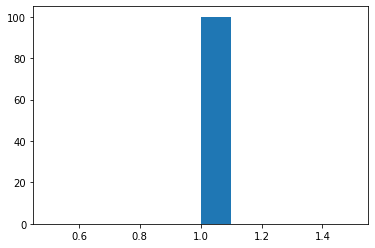

In [21]:
plt.hist(preds_noise[:,0])

ECE = 0.550


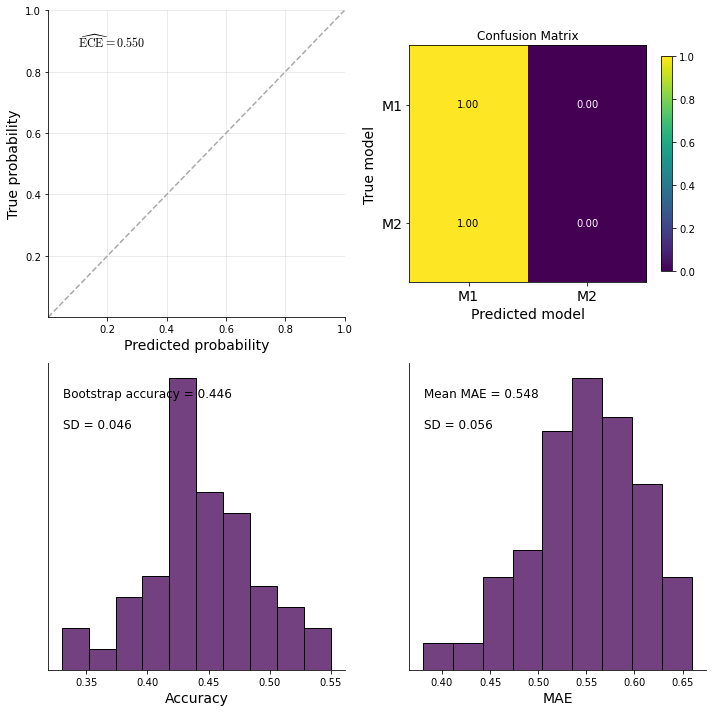

In [22]:
val_sims_noise = {'X' : sims_noise[2], 'm' : sims_noise[0]}
perf_tester(probability_net, summary_net, val_sims_noise, n_cal_bins=15)